# Task Overview

Your task will be to implement a *RevNet* (Reversible Residual Network) – a variant of ResNet where each layer's activations can be reconstructed exactly from the next layer. Therefore, the activations for most layers need not be stored in memory to perform backpropagation.

You can find more information about RevNet here: [link](https://arxiv.org/pdf/1707.04585.pdf)

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (10pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 2pt implement the mini-batch update
  - 5pt implement the backpropagation (note: if you implement backpropagation example-by-example instead of whole minibatch at once, you will get maximum of 2pt for this part)
2. Train the models (find proper hyperparameters). Visualize training of your best model (plot training and test loss/accuracy in time). Your model should reach at least 96% accuracy. Use clear ml for logging your scores. Make a comparison of memory usage for your network and the network you implemented in lab 3.
  - 1pt for accuracy above 96%
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.



## Potential questions, clarifications
- Q: Can I save the output of the last layer before classification (a -> 10)?
  - Yes.
- Q: MNIST has only one channel, how do I split that into two groups for implementing ReVNet blocks?
  - You can split activations into two groups, so if a layer has size $a$ you can split it into $2 \cdot a/2$.
- Q: Can I modify code of ReVNet outside #Your code goes here # to include logging?
  - Yes, in ReVNet.SGD

# Imports

In [ ]:
!pip install clearml --quiet
!pip install memory-profiler --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.2 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
from torchvision import datasets, transforms
from clearml import Task
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
%load_ext memory_profiler

# Dataset loading


In [ ]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2024-09-08 20:37:27--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.162.64, 16.182.102.64, 52.216.52.152, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.162.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  2.10MB/s    in 11s     

2024-09-08 20:37:39 (976 KB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [ ]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [ ]:
### Your code goes here ###
CLEARML_WEB_HOST="https://app.clear.ml/"
CLEARML_API_HOST="https://api.clear.ml"
CLEARML_FILES_HOST="https://files.clear.ml"
CLEARML_API_ACCESS_KEY=""
CLEARML_API_SECRET_KEY=""

Task.set_credentials(
    api_host=CLEARML_API_HOST,
    web_host=CLEARML_WEB_HOST,
    files_host=CLEARML_FILES_HOST,
    key=CLEARML_API_ACCESS_KEY,
    secret=CLEARML_API_SECRET_KEY)

task = Task.init(
    project_name='hw1',
    task_name='Track experiment progress',
)

params_revnet = {
    'epochs': 40,
    'mini_batch_size': 100,
    'learning_rate': 0.3,
    'layers': [784,512,512,10]
}

params_network = {
    'epochs': 100,
    'mini_batch_size': 100,
    'learning_rate': 0.1,
    'layers': [784,100,30,10]
}

###########################

ClearML Task: created new task id=0acf7070c49c4e0fb0edb80794034201
2024-08-30 11:25:10,168 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/4fc8cbc6862d46f0b4f63235cc5e0790/experiments/0acf7070c49c4e0fb0edb80794034201/output/log


/usr/local/lib/python3.10/dist-packages/clearml/utilities/process/mp.py:629: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



# Network definition (as in laboratory 3)


In [ ]:
%%file network.py
import random
import numpy as np


def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

def cross_entropy(x, y):
    ### Your code goes here ###
    return -np.sum(y*np.log(x))
    ###########################

class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def compute_loss(self, x, y):
      y_pred = self.feedforward(x)
      loss = cross_entropy(y_pred, y.T)
      return loss


    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, logger=None, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)

            train_loss = self.compute_loss(x_train, y_train)
            train_accuracy = self.evaluate(training_data)
            if logger is not None:
                logger.report_scalar("loss", "Network_train", iteration=j, value=train_loss)
                logger.report_scalar("accuracy", "Network_train", iteration=j, value=train_accuracy)

            if test_data:
                loss = self.compute_loss(x_test, y_test)
                accuracy = self.evaluate(test_data)
                print("Epoch: {0}, Loss: {1}, Accuracy: {2}".format(j, loss, accuracy))
                if logger is not None:
                    logger.report_scalar("loss", "Network_test", iteration=j, value=loss)
                    logger.report_scalar("accuracy", "Network_test", iteration=j, value=accuracy)
            else:
                print("Epoch: {0}".format(j))


# ReVNet definition

RevNets are composed of a series of reversible blocks. The channels (in case of MNIST: activations) in each layer are partitioned into two groups (two vectors), denoted $x_1$ and $x_2$.

Forward: Each reversible block takes inputs ($x_1$, $x_2$) and produces outputs produces outputs ($y_1$, $y_2$) using functions F and G (the *residuals*). In this task, implement F and G as MLP layers.

$z_1 = x_1 + \mathcal{F}(x_2)$

$y_2 = x_2 + \mathcal{G}(z_1)$

$y_1 = z_1$

The expressions $y_1$ and $z_1$ have the same value, but they are separate nodes in the computation graph, with $y_2$ depending on $z_1$, not $y_1$. We use this distinction so that we can describe gradient computations in two steps: $∂ℒ/∂y_1$ is the derivative of the loss over $y_1$ when $y_2$ is a fixed constant, while $∂ℒ/∂z_1$ is the derivative over $z_1$, which influences the loss through both y1 and y2.

Reverse: Each layer’s activations can be reconstructed from the next layer’s activations as follows:

$x_2 = y_2 - \mathcal{G}(y_1)$

$x_1 = y_1 - \mathcal{F}(x_2)$

Backpropagation is described in the algorithm below, ($y_1$, $y_2$).
$\bar{y_1}$, $\bar{y_2}$ is the gradient of the loss over $y_1$ and $y_2$, respectively


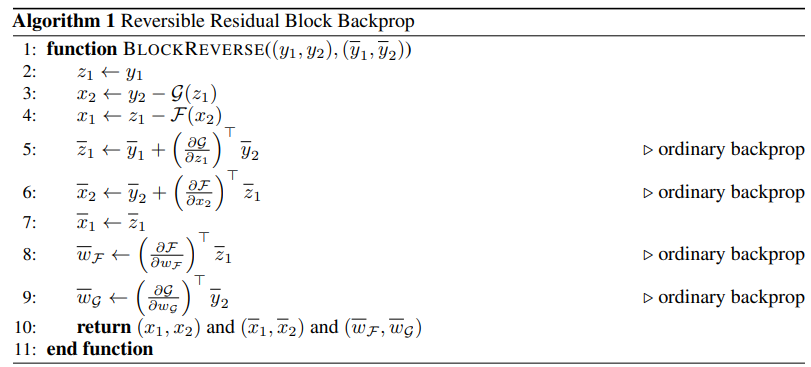

In [62]:
#%%file ReVNet.py
import random
import numpy as np


def softmax(x):
    ### Your code goes here ###
    exp_shifted = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=0, keepdims=True)
    ###########################

def cross_entropy(x, y, epsilon=1e-10):
    ### Your code goes here ###
    x = np.clip(x, epsilon, 1.0)
    return -np.sum(y*np.log(x))
    ###########################

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def relu(x):
    return np.maximum(0,x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)


class ReVNet(object):
    def __init__(self, sizes):
        self.sizes = sizes
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        # sizes should be in form (mnist_size, a, a, a, ...,  a, 10)
        # IMPORTANT: use at least one layer of size a -> a
        ### Your code goes here ###
        self.num_layers = len(sizes)
        self.half_size = sizes[1]//2
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(sizes[1], sizes[0])]+[np.random.randn(2*self.half_size, self.half_size) for _ in range(len(sizes)-3)]+[np.random.randn(sizes[-1], sizes[-2])]
        ###########################

    def feedforward(self, a):
        # Run the network
        ### Your code goes here ###
        a = a.T

        a = (np.matmul(self.weights[0],a)+self.biases[0])
        #a = relu(a)
        a = sigmoid(a)
        x1, x2 = a[:self.half_size, :], a[self.half_size:, :]

        for i in range(1, self.num_layers-2):
            z1 = x1 + sigmoid(np.matmul(self.weights[i][:self.half_size, :], x2) + self.biases[i][:self.half_size, :])
            y2 = x2 + sigmoid(np.matmul(self.weights[i][self.half_size:, :], z1) + self.biases[i][self.half_size:, :])
            x1 = z1
            x2 = y2

        a = np.concatenate((x1, x2), axis=0)
        a = np.matmul(self.weights[-1], a) + self.biases[-1]
        a = softmax(a)
        return a
        ###########################

    def update_mini_batch(self, x_mini_batch, y_mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch.
        # eta is the learning rate
        ### Your code goes here ###
        mini_batch_size = x_mini_batch.shape[0]
        nabla_bs, nabla_Ws = self.backpropagation(x_mini_batch.T, y_mini_batch.T)
        self.biases = [b - (eta/mini_batch_size)*nb
                      for b, nb in zip(self.biases, nabla_bs)]
        self.weights = [w - (eta/mini_batch_size)*nw
                        for w, nw in zip(self.weights, nabla_Ws)]
        ###########################


    def backpropagation(self, x, y):
        ### Your code goes here ###
        input_x = x
        true_y = y
        y = None
        nabla_f = None
        nabla_x1, nabla_x2, nabla_y, nabla_z1 = None, None, None, None
        nabla_z1_dot, nabla_x2_dot = None, None
        nabla_bs = [None for _ in range(len(self.biases))]
        nabla_Ws = [None for _ in range(len(self.weights))]

        x = (np.matmul(self.weights[0],x)+self.biases[0])
        #x = relu(x)
        x=sigmoid(x)
        x1, x2 = x[:self.half_size,:], x[self.half_size:,:]
        for i in range(1, self.num_layers -2):
            z1 = x1 + sigmoid(np.matmul(self.weights[i][:self.half_size, :], x2) + self.biases[i][:self.half_size, :])
            y2 = x2 + sigmoid(np.matmul(self.weights[i][self.half_size:, :], z1) + self.biases[i][self.half_size:, :])
            x1 = z1
            x2 = y2
        a = np.concatenate((x1, x2), axis=0)
        # Store last y for backpropagation
        y=a
        a = np.matmul(self.weights[-1], a) + self.biases[-1]
        # backward pass

        nabla_f = self.cost_derivative(softmax(a), true_y)
        nabla_bs[-1] = np.sum(nabla_f, axis=1).reshape((-1, 1))
        nabla_Ws[-1] = np.matmul(nabla_f, y.T)
        nabla_y = np.matmul(self.weights[-1].T, nabla_f)

        # Backpropagate through the residual blocks
        for k in range(self.num_layers-3, 0, -1):
            # setting block variables
            # 2
            z1 = y[:self.half_size, :]
            z1_dot = np.matmul(self.weights[k][self.half_size:, :], z1) + self.biases[k][self.half_size:, :]
            G_z1 = sigmoid(z1_dot)

            # 3
            x2 = y[self.half_size:, :] - G_z1
            x2_dot = np.matmul(self.weights[k][:self.half_size, :], x2) + self.biases[k][:self.half_size, :]
            F_x2 = sigmoid(x2_dot)

            # 4
            x1 = z1 - F_x2

            # 5
            nabla_z1_dot = G_z1*(1-G_z1)*nabla_y[self.half_size:, :]
            nabla_z1 = nabla_y[:self.half_size, :] + np.matmul(self.weights[k][self.half_size:, :].T, nabla_z1_dot)

            # 6
            nabla_x2_dot = F_x2*(1-F_x2)*nabla_z1
            nabla_x2 = nabla_y[self.half_size:, :] + np.matmul(self.weights[k][:self.half_size, :].T, nabla_x2_dot)

            # 7
            nabla_x1 = nabla_z1

            # 8,9
            nabla_bs[k] = np.zeros(shape=(self.half_size*2, 1))
            nabla_Ws[k] = np.zeros(shape=(self.half_size*2, self.half_size))
            nabla_bs[k][:self.half_size, :] = np.sum(nabla_z1_dot, axis=1).reshape((-1, 1))
            nabla_Ws[k][:self.half_size, :] = np.matmul(nabla_z1_dot, z1.T)
            nabla_bs[k][self.half_size:, :] = np.sum(nabla_x2_dot, axis=1).reshape((-1, 1))
            nabla_Ws[k][self.half_size:, :] = np.matmul(nabla_x2_dot, x2.T)

            y = np.vstack([x1,x2])
            nabla_y = np.vstack([nabla_x1,nabla_x2])

        # backprop for the first layer
        nabla_f = y*(1-y)*nabla_y
        #nabla_f = np.multiply(nabla_y, relu_derivative(y))
        nabla_bs[0] = np.sum(nabla_f, axis=1).reshape((-1, 1))
        nabla_Ws[0] = np.matmul(nabla_f, input_x.T)

        return (nabla_bs, nabla_Ws)
        ###########################

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def evaluate(self, x_test_data, y_test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(x_test_data),axis=0)
        corr = np.argmax(y_test_data,axis=1).T
        return np.mean(pred==corr)

    def compute_loss(self, x, y):
      y_pred = self.feedforward(x)
      loss = cross_entropy(y_pred, y.T)
      return loss

    def SGD(self, training_data, epochs, mini_batch_size, eta, logger=None, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
                y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
                self.update_mini_batch(x_mini_batch, y_mini_batch, eta)

            train_loss = self.compute_loss(x_train, y_train)
            train_accuracy = self.evaluate(x_train, y_train)
            if logger is not None:
                logger.report_scalar("loss", "ReVNet_train", iteration=j, value=train_loss)
                logger.report_scalar("accuracy", "ReVNet_train", iteration=j, value=train_accuracy)

            if test_data:
                loss = self.compute_loss(x_test, y_test)
                accuracy = self.evaluate(x_test, y_test)
                print("Epoch: {0}, Loss: {1}, Accuracy: {2}".format(j, loss, accuracy))
                # Log loss and accuracy to ClearML
                if logger is not None:
                    logger.report_scalar("loss", "ReVNet_test", iteration=j, value=loss)
                    logger.report_scalar("accuracy", "ReVNet_test", iteration=j, value=accuracy)
            else:
                print("Epoch: {0}".format(j))

# Train the network

In [ ]:
task.connect(params_revnet, name='ReVNet')
task.connect(params_network, name='Network')

logger = task.get_logger()

In [ ]:
 ### Your code goes here ###
from ReVNet import *
revnet = ReVNet(params_revnet['layers'])
%mprun -f revnet.SGD -T memory_profile_revnet.txt -r revnet.SGD((x_train, y_train), epochs=params_revnet['epochs'], mini_batch_size=params_revnet['mini_batch_size'], eta=params_revnet['learning_rate'], logger=logger, test_data=(x_test, y_test))
###########################


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 847, in enable
    sys.settrace(self.trace_memory_usage)



Epoch: 0, Loss: 30970.169286334265, Accuracy: 0.899
Epoch: 1, Loss: 19012.647380489125, Accuracy: 0.929
Epoch: 2, Loss: 17739.243492334335, Accuracy: 0.9255
Epoch: 3, Loss: 17789.9479840136, Accuracy: 0.9238
Epoch: 4, Loss: 14240.327018954647, Accuracy: 0.9396
Epoch: 5, Loss: 14282.178549803697, Accuracy: 0.9352
Epoch: 6, Loss: 12533.93952224704, Accuracy: 0.9425
Epoch: 7, Loss: 10236.113025831708, Accuracy: 0.9547
Epoch: 8, Loss: 10962.409696867955, Accuracy: 0.9472
Epoch: 9, Loss: 10934.802465944984, Accuracy: 0.9507
Epoch: 10, Loss: 9840.323991421757, Accuracy: 0.9555
Epoch: 11, Loss: 11074.764978073992, Accuracy: 0.9494
Epoch: 12, Loss: 9679.276172567974, Accuracy: 0.9576
Epoch: 13, Loss: 10773.997474022137, Accuracy: 0.9518
Epoch: 14, Loss: 9388.495927305203, Accuracy: 0.96
Epoch: 15, Loss: 9042.231228396966, Accuracy: 0.9591
Epoch: 16, Loss: 9272.649246454701, Accuracy: 0.9599
Epoch: 17, Loss: 10069.23769554272, Accuracy: 0.957
Epoch: 18, Loss: 9146.125822415434, Accuracy: 0.9622


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 850, in disable
    sys.settrace(self._original_trace_function)



Epoch: 39, Loss: 8485.077972104635, Accuracy: 0.9672


*** Profile printout saved to text file memory_profile_revnet.txt. 


In [ ]:
from network import *
network = Network(params_network['layers'])
%mprun -f network.SGD -T memory_profile_network.txt -r network.SGD((x_train, y_train), epochs=params_network['epochs'], mini_batch_size=params_network['mini_batch_size'], eta=params_network['learning_rate'], logger=logger, test_data=(x_test, y_test))

Epoch: 0, Loss: 42567.749475473334, Accuracy: 0.1348
Epoch: 1, Loss: 40146.90183533972, Accuracy: 0.1735
Epoch: 2, Loss: 37126.25054402263, Accuracy: 0.2223
Epoch: 3, Loss: 34522.14373082262, Accuracy: 0.265
Epoch: 4, Loss: 32542.355822215995, Accuracy: 0.3106
Epoch: 5, Loss: 30995.744350010227, Accuracy: 0.3624
Epoch: 6, Loss: 29742.60424755595, Accuracy: 0.3983
Epoch: 7, Loss: 28730.88567400012, Accuracy: 0.4318
Epoch: 8, Loss: 27897.03877061342, Accuracy: 0.454
Epoch: 9, Loss: 27175.70604502787, Accuracy: 0.4753
Epoch: 10, Loss: 26526.301517223248, Accuracy: 0.4946
Epoch: 11, Loss: 25938.047002367293, Accuracy: 0.5139
Epoch: 12, Loss: 25404.5639951159, Accuracy: 0.5333
Epoch: 13, Loss: 24913.786937309764, Accuracy: 0.548
Epoch: 14, Loss: 24450.51449129058, Accuracy: 0.5626
Epoch: 15, Loss: 23996.454643430163, Accuracy: 0.5741
Epoch: 16, Loss: 23530.006847136814, Accuracy: 0.5824
Epoch: 17, Loss: 23020.444404567166, Accuracy: 0.5921
Epoch: 18, Loss: 22411.231315837398, Accuracy: 0.60

In [ ]:
task.close()

# Training plots for the best training

--2024-08-30 12:15:08--  https://drive.google.com/uc?export=download&id=1V6vRb9_qXKpu8VX4USnipVhEa0WWsk36
Resolving drive.google.com (drive.google.com)... 74.125.126.138, 74.125.126.113, 74.125.126.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.126.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1V6vRb9_qXKpu8VX4USnipVhEa0WWsk36&export=download [following]
--2024-08-30 12:15:09--  https://drive.usercontent.google.com/download?id=1V6vRb9_qXKpu8VX4USnipVhEa0WWsk36&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134753 (132K) [image/png]
Saving to: ‘accuracy.png’

accuracy.png        100%[===================>] 131.59K  --.-KB/s    in 0.002s  

2

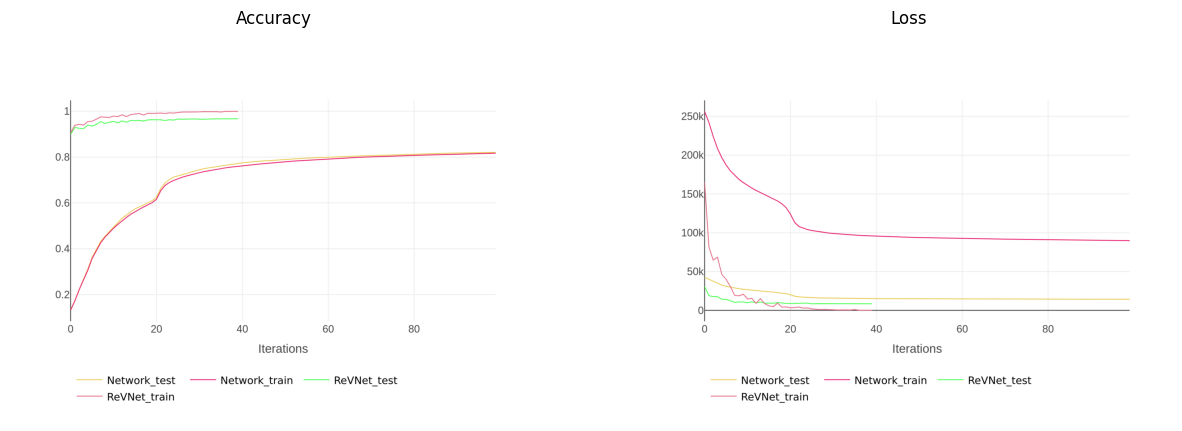

In [ ]:
 ### Your code goes here ###
!wget -O accuracy.png "https://drive.google.com/uc?export=download&id=1V6vRb9_qXKpu8VX4USnipVhEa0WWsk36"
!wget -O loss.png "https://drive.google.com/uc?export=download&id=1USPJCt65gZFpbUX8I5zO1oo3Lj_fNooN"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('accuracy.png')
img2 = mpimg.imread('loss.png')

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(img1)
axs[0].axis('off')
axs[0].set_title('Accuracy')

axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title('Loss')

plt.show()
###########################

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

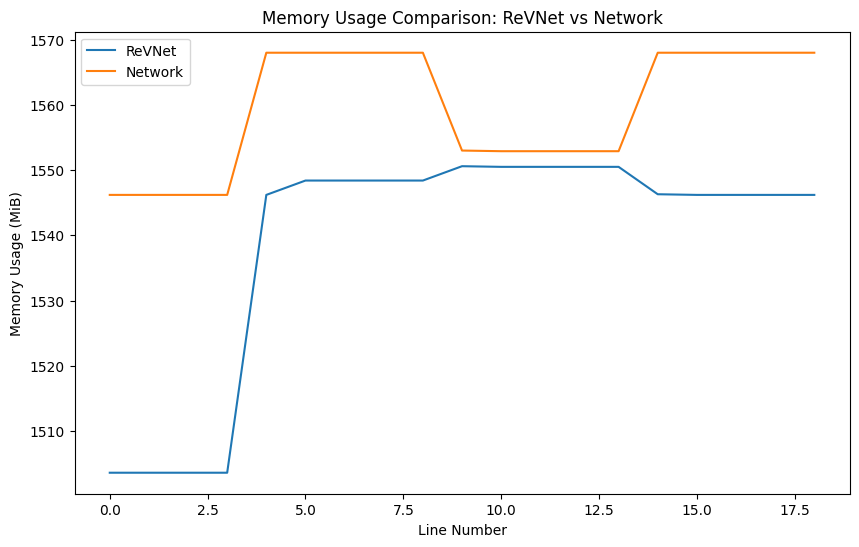

In [ ]:
 ### Your code goes here ###
def extract_memory_usage(file_path):
    memory_usage = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'MiB' in line:
                parts = line.split()
                mem_usage = float(parts[1])
                memory_usage.append(mem_usage)
    return memory_usage

revnet_memory_usage = extract_memory_usage('memory_profile_revnet.txt')
network_memory_usage = extract_memory_usage('memory_profile_network.txt')

plt.figure(figsize=(10, 6))
plt.plot(revnet_memory_usage, label='ReVNet')
plt.plot(network_memory_usage, label='Network')
plt.xlabel('Line Number')
plt.ylabel('Memory Usage (MiB)')
plt.title('Memory Usage Comparison: ReVNet vs Network')
plt.legend()
###########################

[memory_profile_network.txt](https://drive.google.com/file/d/1AFpCRSuygKWP-rdaysbBFR74VP0qxo1d/view?usp=sharing)

[memort_profile_revnet.txt](https://drive.google.com/file/d/1l34vzuWYt5mGOUkNkzFO2dcmVyf3oeNE/view?usp=sharing)

<ipython-input-62-618bde778d4b>:19: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Epoch: 0, Loss: 162218.74201907925, Accuracy: 0.2954
Epoch: 1, Loss: 156227.16626459436, Accuracy: 0.3215
Epoch: 2, Loss: 192680.32058174175, Accuracy: 0.1632
Epoch: 0, Loss: 23519.086740306884, Accuracy: 0.0958
Epoch: 1, Loss: 23476.650621564233, Accuracy: 0.0958
Epoch: 2, Loss: 23476.02293719006, Accuracy: 0.0958


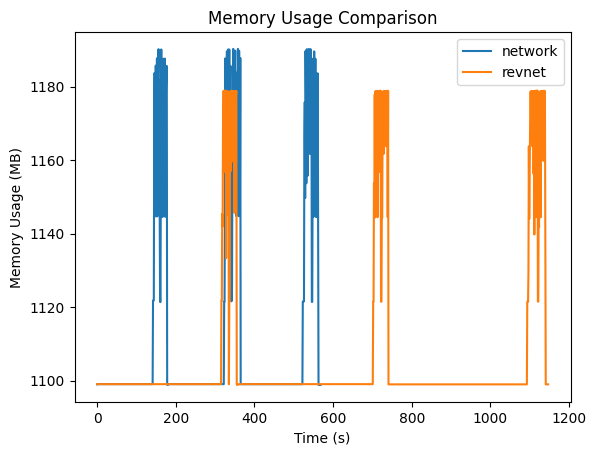

In [63]:
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

revnet = ReVNet([784, *[50]*20, 10])
network = Network([784, *[50]*20, 10])

memory_usage_revnet = memory_usage((revnet.SGD, ((x_train, y_train),
                                              3,
                                              10,
                                              0.9,
                                              None,
                                              (x_test, y_test))))

memory_usage_network = memory_usage((network.SGD, ((x_train, y_train),
                                               3,
                                               10,
                                               0.9,
                                               None,
                                              (x_test, y_test))))


plt.plot(memory_usage_network, label='network')

plt.plot(memory_usage_revnet, label='revnet')

plt.xlabel('Time (s)')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison')
plt.legend()

plt.show()


In [64]:
np.mean(memory_usage_nn1), np.mean(memory_usage_nn2)

(1114.22216505885, 1248.9060956460019)